In [2]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
#r2_score range -> 1 to negative
#1 - best fit, 0 to negative - not applicable
from sklearn.metrics import accuracy_score, r2_score 
import pandas as pd
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.neural_network import MLPRegressor
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
from tabulate import tabulate
import numpy as np

In [4]:
april2024_data = pd.read_parquet("24_04.parquet")
april2024_data = april2024_data[april2024_data["exit state"] == "completed"]
april2024_data.head()

,jid,usr,jnam,cnumr,cnumat,cnumut,nnumr,adt,qdt,schedsdt,...,jobenv_req,freq_req,freq_alloc,flops,mbwidth,opint,pclass,embedding,exit state,duration
8,jid_23119026,usr_2771,jnam_2301971,48,48,48,1,2024-04-07 01:36:14+09,2024-04-07 01:36:14+09,2024-04-07 01:36:14+09,...,jobenv_req_1,2000,2000,6.541158e+09,2.310258e+10,0.283135,memory-bound,"[-0.07739889, -0.01745062, -0.06704966, -0.004...",completed,3129.0
9,jid_23119027,usr_3004,jnam_73059,144,144,144,3,2024-04-05 18:17:10+09,2024-04-05 18:17:10+09,2024-04-07 02:00:57+09,...,jobenv_req_1,2000,2000,1.909095e+11,6.373276e+11,0.299547,memory-bound,"[-0.0914019, 0.03826673, -0.027243994, -0.0132...",completed,1647.0
17,jid_23119035,usr_1839,jnam_2301975,48,48,20,1,2024-04-07 22:31:26+09,2024-04-07 22:31:26+09,2024-04-07 22:31:26+09,...,jobenv_req_1,2000,2000,1.318028e+04,4.986295e+08,0.000026,memory-bound,"[-0.121330984, -0.015676264, -0.05872378, -0.0...",completed,3.0
21,jid_23119035,usr_1839,jnam_2301975,48,48,20,1,2024-04-07 22:31:26+09,2024-04-07 22:31:26+09,2024-04-07 22:31:26+09,...,jobenv_req_1,2000,2000,1.322449e+04,6.481916e+08,0.000020,memory-bound,"[-0.121330984, -0.015676264, -0.05872378, -0.0...",completed,3.0
27,jid_23119035,usr_1839,jnam_2301975,48,48,20,1,2024-04-07 22:31:26+09,2024-04-07 22:31:26+09,2024-04-07 22:31:26+09,...,jobenv_req_1,2000,2000,1.317837e+04,7.016042e+08,0.000019,memory-bound,"[-0.121330984, -0.015676264, -0.05872378, -0.0...",completed,3.0


In [6]:
#sorting the dataset by the 'adt' column
april2024_data['adt'] = pd.to_datetime(april2024_data['adt'])
april2024_data = april2024_data.sort_values(by='adt', ascending=True)
april2024_data = april2024_data.reset_index(drop=True)
#gives the week number
april2024_data['week'] = april2024_data['adt'].dt.isocalendar().week
#april2021_data.head()

In [8]:
april2024_data['week'] = april2024_data['week'].fillna(-1)
unique_weeks = sorted(april2024_data['week'].unique())
#print(unique_weeks)

In [10]:
#MEMORY SIZE USED
input_mmsize = ['usr', 'jnam', 'mszl', 'cnumr', 'nnumr', 'freq_req', 'elpl']
output_mmsize = ['mmszu']

#using label encoding for the string datatype columns
label_encoders = {}
for col in [ 'usr', 'jnam']:
    le = LabelEncoder()
    april2024_data[col] = le.fit_transform(april2024_data[col])
    #storing label encoders if required later
    label_encoders[col] = le

y_test_all_mmsize = []
y_pred_all_mmsize_RF = []
y_pred_all_mmsize_MLP = []

In [12]:
#data splitting(with replacement) - bootstrapping -> every decision tree trained indiviually
#n_estimators - number of trees - majority of all the decisions
#random_state - shuffle
RF_model = RandomForestRegressor(n_estimators=100, random_state=42)

#Weights represent the importance of each input
MLP_NN_model = MLPRegressor(hidden_layer_sizes=(4,),  # 1 hidden layer with 4 neurons (any number of neuron layers possible)
                   activation='relu',        # ReLU activation function - whether a neuron should be activated based on the weighter sum of inputs.
                   solver='adam',            # Adam optimizer - how the network updates its weights during training
                   learning_rate_init=0.1,   # Learning rate - how quickly the model learns
                   max_iter=5000,            # Training iterations
                   random_state=42)

In [14]:
total_low_RF = 0       
total_mid_RF = 0       
total_high_RF = 0 
total_low_MLP = 0       
total_mid_MLP = 0       
total_high_MLP = 0 

In [16]:
for week in sorted(unique_weeks):
    weekly_data = april2024_data[april2024_data['week'] == week]
    
    X = weekly_data[input_mmsize]
    Y = weekly_data[output_mmsize]
    
    # Train-test split (80% train, 20% test)
    X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42, shuffle=False)
    #2D array to 1D array for models
    Y_train = Y_train.values.ravel()
    
    # Standardize training data only
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    RF_model.fit(X_train_scaled, Y_train)
    Y_pred_RF = RF_model.predict(X_test_scaled)

    MLP_NN_model.fit(X_train_scaled, Y_train)
    Y_pred_MLP = MLP_NN_model.predict(X_test_scaled)

    y_test_all_mmsize.extend(Y_test.values)
    y_pred_all_mmsize_RF.extend(Y_pred_RF)
    y_pred_all_mmsize_MLP.extend(Y_pred_MLP)

    ratios = Y_pred_RF / Y_test.values
    low = np.sum(ratios < 0.85)
    mid = np.sum((ratios >= 0.85) & (ratios < 1.15))
    high = np.sum(ratios >= 1.15)

    total_low_RF += low
    total_mid_RF += mid
    total_high_RF += high

    ratios = Y_pred_MLP / Y_test.values
    low = np.sum(ratios < 0.85)
    mid = np.sum((ratios >= 0.85) & (ratios < 1.15))
    high = np.sum(ratios >= 1.15)

    total_low_MLP += low
    total_mid_MLP += mid
    total_high_MLP += high  

/Users/nishthaladi/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (5000) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/nishthaladi/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (5000) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/nishthaladi/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (5000) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/nishthaladi/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (5000) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/n

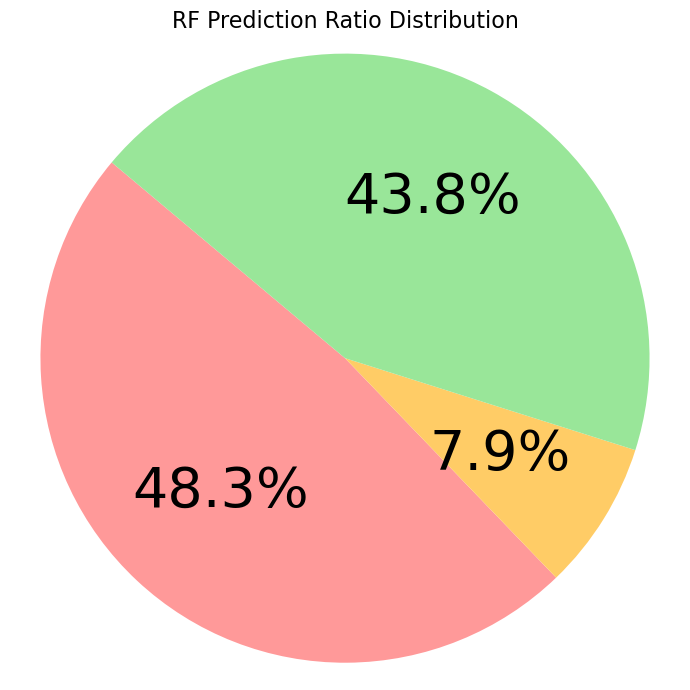

In [18]:
sizes = [total_low_RF, total_mid_RF, total_high_RF]
darker_colors = ['#ff9999', '#ffcc66', '#99e699']  # Darker red-yellow-green tones

plt.figure(figsize=(7, 7))
plt.pie(
    sizes, 
    colors=darker_colors, 
    autopct=lambda pct: f'{pct:.1f}%',  # keep 1 decimal point
    startangle=140,
    textprops={'fontsize': 40}  # Larger font size for labels and percentages
)
plt.title('RF Prediction Ratio Distribution', fontsize=16)
plt.axis('equal')  # Ensures the pie is a circle
plt.tight_layout()
plt.show()

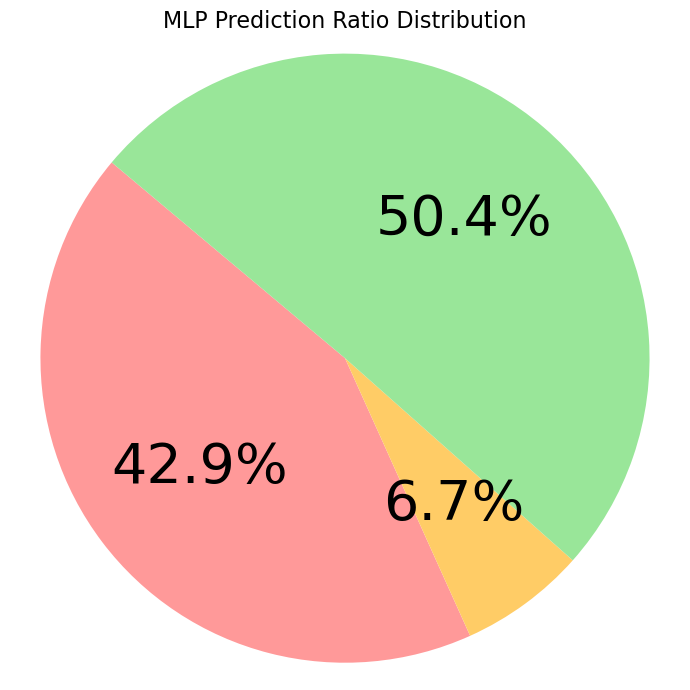

In [20]:
sizes = [total_low_MLP, total_mid_MLP, total_high_MLP]
darker_colors = ['#ff9999', '#ffcc66', '#99e699']  # Darker red-yellow-green tones

plt.figure(figsize=(7, 7))
plt.pie(
    sizes, 
    colors=darker_colors, 
    autopct=lambda pct: f'{pct:.1f}%',  # keep 1 decimal point
    startangle=140,
    textprops={'fontsize': 40}  # Larger font size for labels and percentages
)
plt.title('MLP Prediction Ratio Distribution', fontsize=16)
plt.axis('equal')  # Ensures the pie is a circle
plt.tight_layout()
plt.show()

In [22]:
from sklearn.cluster import KMeans
RF_cluster_0 = RandomForestRegressor(n_estimators=100, random_state=42)
RF_cluster_1 = RandomForestRegressor(n_estimators=100, random_state=42)
RF_cluster_2 = RandomForestRegressor(n_estimators=100, random_state=42)
y_test_all_cluster = []
y_pred_all_cluster = []
total_low_cluster = 0
total_mid_cluster = 0
total_high_cluster = 0

In [24]:
for week in sorted(unique_weeks):
    weekly_data = april2024_data[april2024_data['week'] == week]
    X = weekly_data[input_mmsize]
    Y = weekly_data[output_mmsize]

    X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, shuffle=False, random_state=42)
    Y_train = Y_train.values.ravel()

    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    kmeans = KMeans(n_clusters=3, n_init=10, random_state=42)
    train_clusters = kmeans.fit_predict(X_train_scaled)

    RF_cluster_0.fit(X_train_scaled[train_clusters == 0], Y_train[train_clusters == 0])
    RF_cluster_1.fit(X_train_scaled[train_clusters == 1], Y_train[train_clusters == 1])
    RF_cluster_2.fit(X_train_scaled[train_clusters == 2], Y_train[train_clusters == 2])

    test_clusters = kmeans.predict(X_test_scaled)

    for i, cluster_id in enumerate(test_clusters):
        x_sample = X_test_scaled[i].reshape(1, -1)
        y_true = Y_test.values[i]

        if cluster_id == 0:
            y_pred = RF_cluster_0.predict(x_sample)[0]
        elif cluster_id == 1:
            y_pred = RF_cluster_1.predict(x_sample)[0]
        else:
            y_pred = RF_cluster_2.predict(x_sample)[0]

        y_test_all_cluster.append(y_true)
        y_pred_all_cluster.append(y_pred)

        ratios = y_pred / y_true
        if ratios < 0.85:
            total_low_cluster += 1
        elif 0.85 <= ratios < 1.15:
            total_mid_cluster += 1
        else:
            total_high_cluster += 1

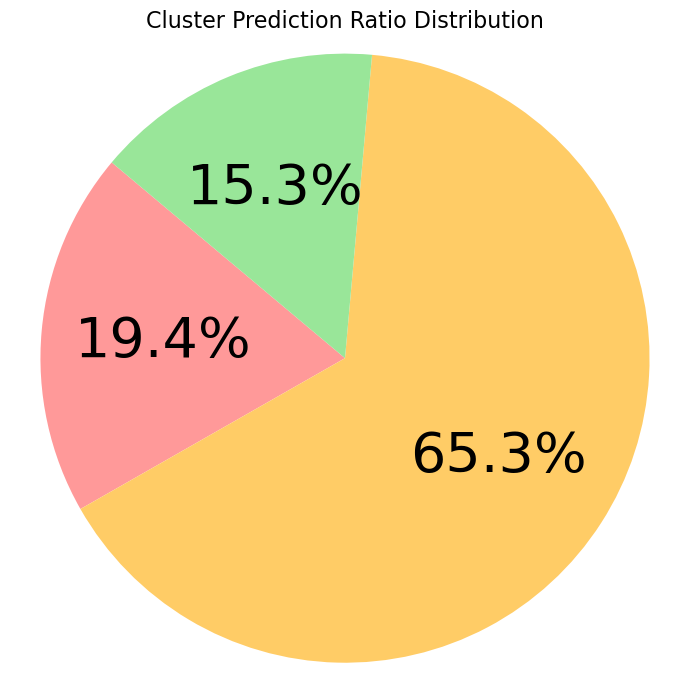

In [26]:
sizes = [total_low_cluster, total_mid_cluster, total_high_cluster]
darker_colors = ['#ff9999', '#ffcc66', '#99e699']  # Darker red-yellow-green tones

plt.figure(figsize=(7, 7))
plt.pie(
    sizes, 
    colors=darker_colors, 
    autopct=lambda pct: f'{pct:.1f}%',  # keep 1 decimal point
    startangle=140,
    textprops={'fontsize': 40}  # Larger font size for labels and percentages
)
plt.title('Cluster Prediction Ratio Distribution', fontsize=16)
plt.axis('equal')  # Ensures the pie is a circle
plt.tight_layout()
plt.show()

In [28]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam

In [30]:
seq_model = Sequential([
    Dense(4, activation='relu', input_shape=(X_train.shape[1],)),  # 1 hidden layer with 4 neurons
    Dense(1)  # Output layer with 1 neuron for regression
])

/Users/nishthaladi/anaconda3/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [32]:
y_test_all_mmsize_seq = []
y_pred_all_mmsize_seq = []

In [34]:
total_low_seq= 0
total_mid_seq = 0
total_high_seq = 0

In [36]:
for week in sorted(unique_weeks):
    weekly_data = april2024_data[april2024_data['week'] == week]

    X = weekly_data[input_mmsize]
    Y = weekly_data[output_mmsize]

    X_train, X_test, Y_train, Y_test = train_test_split(
        X, Y, test_size=0.2, random_state=42, shuffle=False
    )
    Y_train = Y_train.values.ravel()

    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    seq_model.compile(optimizer=Adam(learning_rate=0.1), loss='mean_squared_error')

    seq_model.fit(X_train_scaled, Y_train, epochs=50, verbose=0)

    Y_pred_SEQ = seq_model.predict(X_test_scaled).flatten() 

    for i in range(len(Y_test)):
        y_true = Y_test.values[i]
        y_pred = Y_pred_SEQ[i]

        y_test_all_mmsize_seq.append(y_true)
        y_pred_all_mmsize_seq.append(y_pred)

        ratio = y_pred / y_true

        if ratio < 0.85:
            total_low_seq += 1
        elif 0.85 <= ratio < 1.15:
            total_mid_seq += 1
        else:
            total_high_seq += 1

110/110 ━━━━━━━━━━━━━━━━━━━━ 0s 352us/step
477/477 ━━━━━━━━━━━━━━━━━━━━ 0s 270us/step
625/625 ━━━━━━━━━━━━━━━━━━━━ 0s 263us/step
745/745 ━━━━━━━━━━━━━━━━━━━━ 0s 260us/step
164/164 ━━━━━━━━━━━━━━━━━━━━ 0s 315us/step


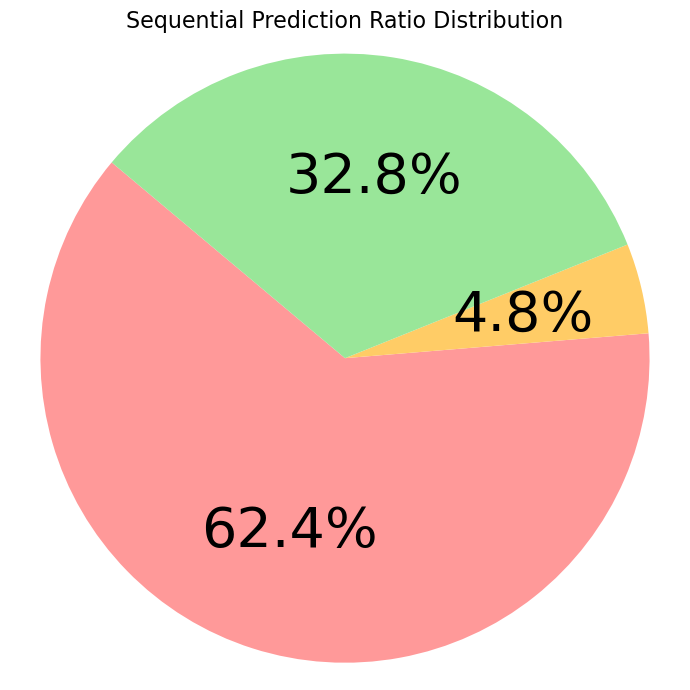

In [38]:
sizes = [total_low_seq, total_mid_seq, total_high_seq]
darker_colors = ['#ff9999', '#ffcc66', '#99e699']  # Darker red-yellow-green tones

plt.figure(figsize=(7, 7))
plt.pie(
    sizes, 
    colors=darker_colors, 
    autopct=lambda pct: f'{pct:.1f}%',  # keep 1 decimal point
    startangle=140,
    textprops={'fontsize': 40}  # Larger font size for labels and percentages
)
plt.title('Sequential Prediction Ratio Distribution', fontsize=16)
plt.axis('equal')  # Ensures the pie is a circle
plt.tight_layout()
plt.show()